In [1]:
import os
import torch
import numpy as np

from torch.utils.data import Dataset
from torchvision.transforms import Resize, Compose, ToTensor

from PIL import Image

In [26]:
class CityScapes(Dataset):
    def __init__(self, root_dir, split='train', mode='multiple', label_raw=False):
        super(CityScapes, self).__init__()
        # Save the root directory of the dataset
        self.root_dir = root_dir
        # Save the Channel mode
        self.mode = mode
        # Save the label raw mode
        self.label_raw = label_raw
        # Reduce the size of the images to 512x1024
        self.transform = Compose([
            # Resize((512, 1024)),
            Resize((128, 256)),
        ])
        # Image and label directories
        self.image_dir = os.path.join(root_dir, 'images', split)
        self.label_dir = os.path.join(root_dir, 'gtFine', split)
        # Get the list of cities
        self.cities = sorted(os.listdir(self.image_dir))

    def convert_from_image_to_label(self, image):
        # Convert the image to a numpy array
        image = np.array(image)

        # Create a new image where each pixel is labeled
        labels = {
            0: 7,   # road
            1: 8,   # sidewalk
            2: 11,  # building
            3: 12,  # wall
            4: 13,  # fence
            5: 17,  # pole
            6: 19,  # traffic light
            7: 20,  # traffic sign
            8: 21,  # vegetation
            9: 22,  # terrain
            10: 23, # sky
            11: 24, # person
            12: 25, # rider
            13: 26, # car
            14: 27, # truck
            15: 28, # bus
            16: 31, # train
            17: 32, # motorcycle
            18: 33, # bicycle
            255: 0  # everthing else
        }

        # Create a new image where each pixel is labeled
        new_image = np.zeros_like(image)
        for k, v in labels.items():
            new_image[image == k] = v

        # Convert the image to a tensor
        return torch.tensor(new_image, dtype=torch.long)
    
    def convert_from_label_to_image(self, label):
        # Create a new image where each pixel is labeled
        labels = {
            7: 0,   # road
            8: 1,   # sidewalk
            11: 2,  # building
            12: 3,  # wall
            13: 4,  # fence
            17: 5,  # pole
            19: 6,  # traffic light
            20: 7,  # traffic sign
            21: 8,  # vegetation
            22: 9,  # terrain
            23: 10, # sky
            24: 11, # person
            25: 12, # rider
            26: 13, # car
            27: 14, # truck
            28: 15, # bus
            31: 16, # train
            32: 17, # motorcycle
            33: 18, # bicycle
            0: 255  # everthing else
        }

        # Create a new image where each pixel is labeled
        new_label = np.zeros_like(label)
        for k, v in labels.items():
            new_label[label == k] = v

        # Convert the image to a tensor
        return torch.tensor(new_label, dtype=torch.long)

    def __getitem__(self, idx):
        # Find the city and image index
        for city in self.cities:
            # Get the list of images in the city
            images = os.listdir(os.path.join(self.image_dir, city))
            # Check if the index is in the range of the city
            if idx < len(images):
                # If it is, break the loop
                break
            # Otherwise, subtract the number of images in the city from the index
            # This will move the index to the next city
            idx -= len(images)

        # Load the image and label
        image = self.transform(Image.open(os.path.join(self.image_dir, city, images[idx])))
        if self.mode == 'multiple':
            label = self.transform(Image.open(os.path.join(self.label_dir, city, images[idx].replace('leftImg8bit', 'gtFine_color'))))
        else:
            label = self.transform(Image.open(os.path.join(self.label_dir, city, images[idx].replace('leftImg8bit', 'gtFine_labelTrainIds'))))

            if self.label_raw == False:
                # Transform  each pixel to a label
                label = self.convert_from_image_to_label(label)
        
        # Return the image and label
        return image, label

    def __len__(self):
        # Sum the number of images in each city
        # This is the total number of images in the dataset
        return sum(len(os.listdir(os.path.join(self.image_dir, city))) for city in self.cities)

## DataClass test - Color mode

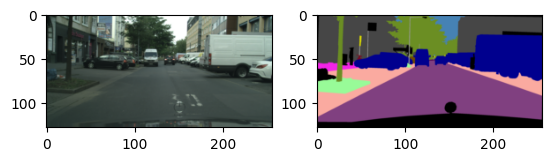

In [37]:
import matplotlib.pyplot as plt

# Create the dataset
# In multiple mode the label encoding is not done!
dataset = CityScapes(root_dir="Cityspaces", mode='multiple')
# Get the first image and label
image, label = dataset[0]

# Plot the image and label
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.show()

## DataClass test - IDX mode (no label)

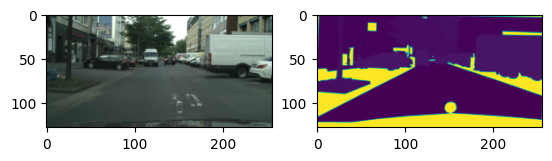

In [41]:
import matplotlib.pyplot as plt

# Create the dataset
dataset = CityScapes(root_dir="Cityspaces", mode='single', label_raw=True)
# Get the first image and label
image, label = dataset[0]

# Plot the image and label
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.show()

## DataClass test - IDX mode (label)

In [56]:
import torch

# Create the dataset
dataset = CityScapes(root_dir="Cityspaces", mode='single', label_raw=False)
# Get the first image and label
image, label = dataset[0]

# Print the values present in the label image
print(f"Label values: {torch.unique(label).numpy()}")
print(f"Number of classes: {len(torch.unique(label))}")

Label values: [ 0  7  8 11 12 13 17 19 20 21 22 23 24 25 26 27 28 31 32 33]
Number of classes: 20
